<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Extraction</a></span><ul class="toc-item"><li><span><a href="#Time-domain-features" data-toc-modified-id="Time-domain-features-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time domain features</a></span><ul class="toc-item"><li><span><a href="#Mean" data-toc-modified-id="Mean-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Mean</a></span></li><li><span><a href="#Standard-deviation-(SD)" data-toc-modified-id="Standard-deviation-(SD)-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Standard deviation (SD)</a></span></li><li><span><a href="#Skewness" data-toc-modified-id="Skewness-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Skewness</a></span></li><li><span><a href="#Kurtosis" data-toc-modified-id="Kurtosis-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Kurtosis</a></span></li><li><span><a href="#Zero-crossing" data-toc-modified-id="Zero-crossing-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Zero crossing</a></span></li><li><span><a href="#Hjorth-parameters" data-toc-modified-id="Hjorth-parameters-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Hjorth parameters</a></span></li></ul></li></ul></li></ul></div>

In [20]:
from hdf5storage import loadmat
import numpy as np
from misleeputils import signal_filter, plot_3_states
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wake_data = list(loadmat(
    r'E:\workplace\EEGProcessing\00_DATA\20230922_non-shielding wires w plug & grounding\PSD\Merged dataset\wake_data.mat').values())[-1][1]
nrem_data = list(loadmat(
    r'E:\workplace\EEGProcessing\00_DATA\20230922_non-shielding wires w plug & grounding\PSD\Merged dataset\nrem_data.mat').values())[-1][1]
rem_data = list(loadmat(
    r'E:\workplace\EEGProcessing\00_DATA\20230922_non-shielding wires w plug & grounding\PSD\Merged dataset\rem_data.mat').values())[-1][1]

# Sampling frequency
sf = 305
# example data length (seconds)
eg_len = 30
# example data of 3 states
wake_eg = wake_data[:eg_len*sf]
nrem_eg = nrem_data[:eg_len*sf]
rem_eg = rem_data[:eg_len*sf]

del wake_data, nrem_data, rem_data

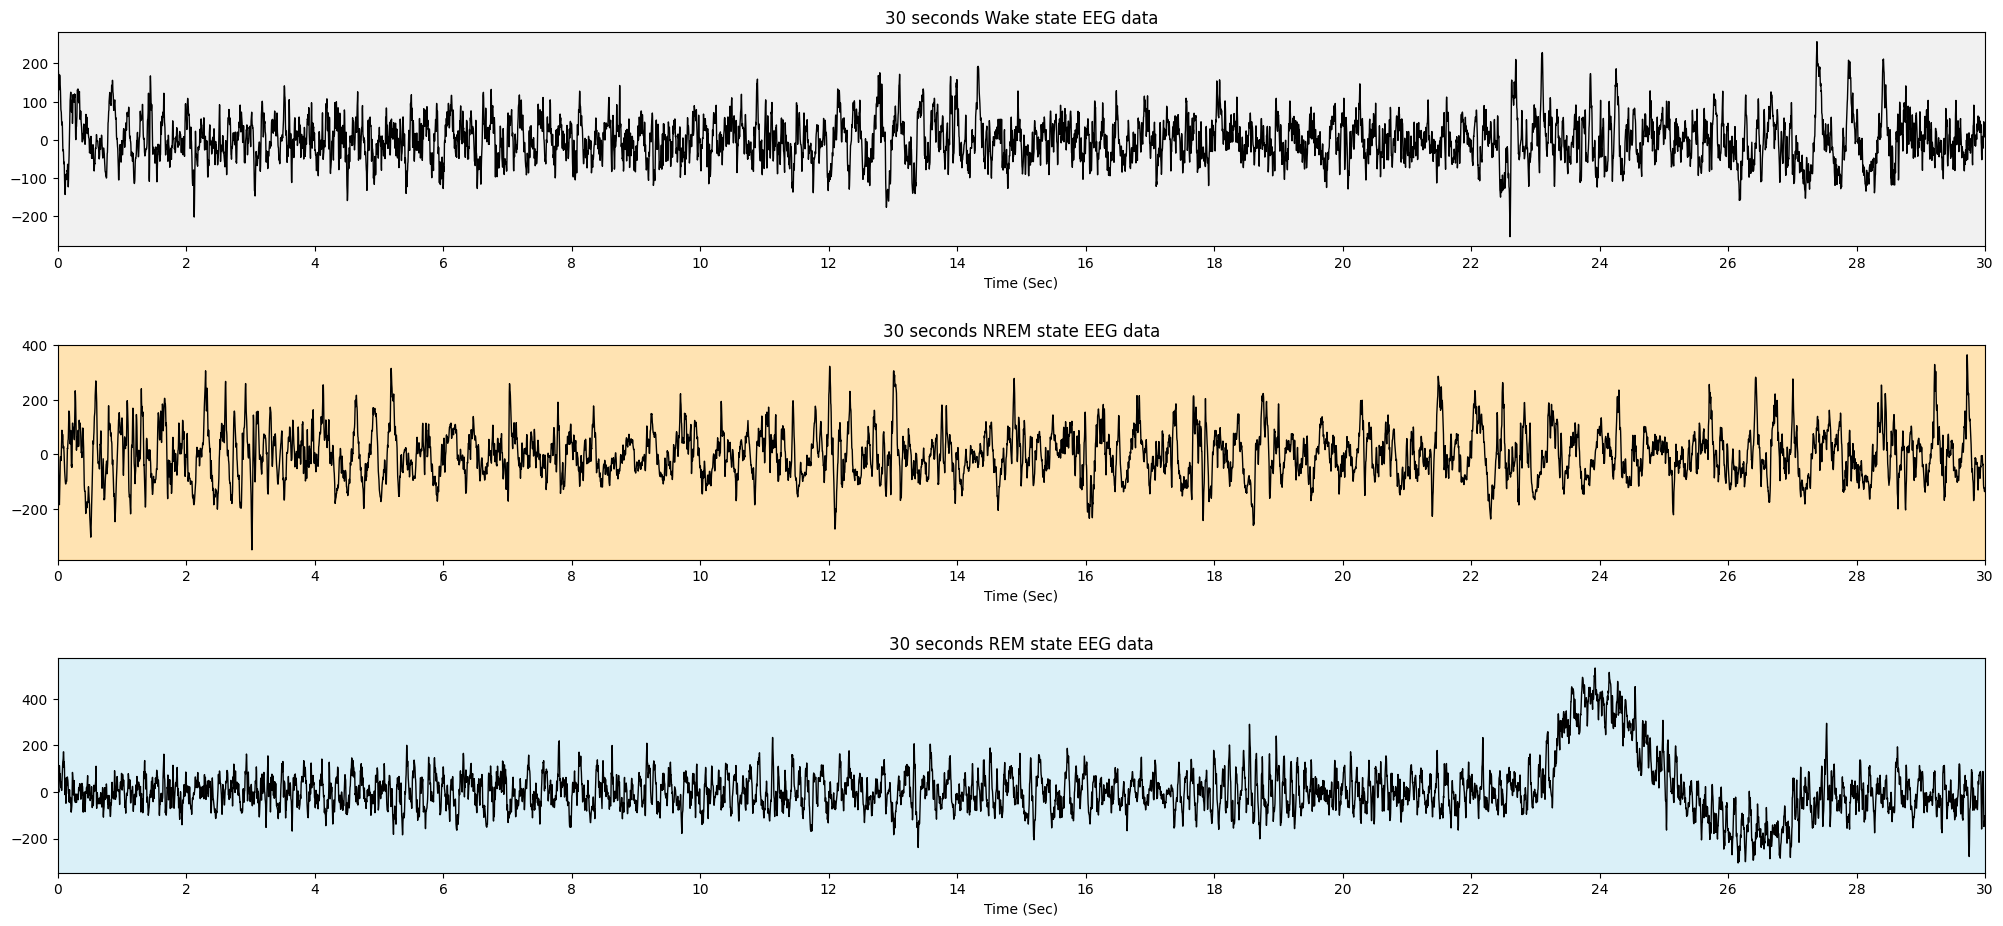

In [3]:
plot_3_states(wake_eg=wake_eg, nrem_eg=nrem_eg, rem_eg=rem_eg, 
              eg_len=eg_len, sf=sf, 
              wake_title=f"{eg_len} seconds Wake state EEG data", 
              nrem_title=f"{eg_len} seconds NREM state EEG data", 
              rem_title=f"{eg_len} seconds REM state EEG data")


As EEG signal have strong variability and are easily disturbed by other physiological signals and the external environment, it is necessary to preprocess the original data to eliminate the noise interference. Here we use a finite impulse response [FIR] bandpass filter in the range of 0.5-45 Hz to denoise the original EEG data.

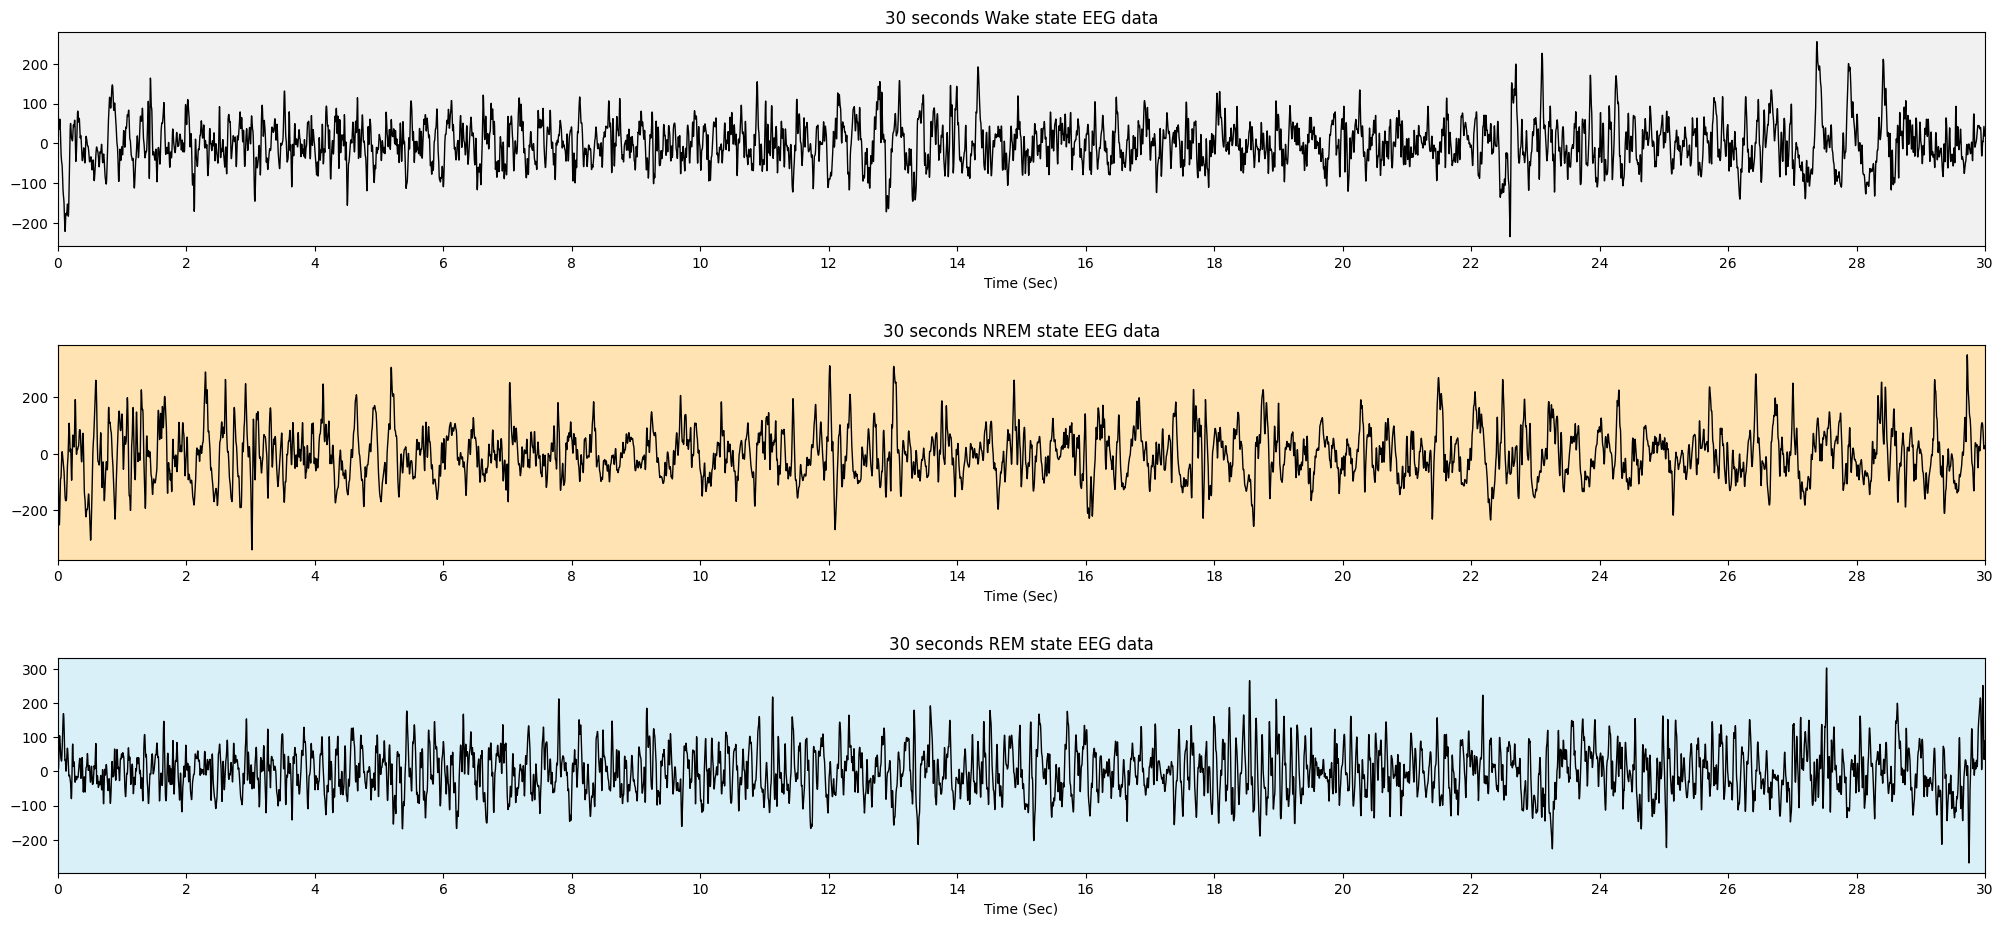

In [4]:
# 0.5~45 Hz bandpass filter
wake_eg = signal_filter(data=wake_eg, sf=sf, btype='bandpass', low=0.5, high=45)
nrem_eg = signal_filter(data=nrem_eg, sf=sf, btype='bandpass', low=0.5, high=45)
rem_eg = signal_filter(data=rem_eg, sf=sf, btype='bandpass', low=0.5, high=45)

plot_3_states(wake_eg=wake_eg, nrem_eg=nrem_eg, rem_eg=rem_eg, 
              eg_len=eg_len, sf=sf, 
              wake_title=f"{eg_len} seconds Wake state EEG data", 
              nrem_title=f"{eg_len} seconds NREM state EEG data", 
              rem_title=f"{eg_len} seconds REM state EEG data")

# Feature Extraction
Here we extract several features (3 aspects), time domain, frequency domain, and nonlinear features.

Reference:

[Evaluation of a Single-Channel EEG-Based Sleep Staging Algorithm](https://doi.org/10.3390%2Fijerph19052845) and 

[Sleep Stage Classification Using EEG Signal Analysis:
A Comprehensive Survey and New Investigation](https://doi.org/10.3390/e18090272).

## Time domain features

### Mean

$$
X_{mean} = \bar{S(n)} = \frac{1}{N}\sum_{n=1}^{N}S(n)
$$

In [181]:
f = 'mean'
mean_wake = wake_eg.mean()
mean_nrem = nrem_eg.mean()
mean_rem = rem_eg.mean()

print(f'Wake data {f}: {mean_wake:.4f}')
print(f'NREM data {f}: {mean_nrem:.4f}')
print(f'REM data {f}: {mean_rem:.4f}')

Wake data mean: -0.5458
NREM data mean: -0.6053
REM data mean: 0.0483


### Standard deviation (SD)

$$
\sigma = \sqrt{\frac{\sum(X-\mu)^2}{N}} = \sqrt{\frac{\sum(X-X_{mean})^2}{N}}
$$

In [182]:
# Self 
np.sqrt(np.mean((wake_eg - mean_wake) ** 2))

53.992823735347635

In [183]:
f = 'standard deviation'
sd_wake = wake_eg.std()
sd_nrem = nrem_eg.std()
sd_rem = rem_eg.std()

print(f'Wake data {f}: {sd_wake:.4f}')
print(f'NREM data {f}: {sd_nrem:.4f}')
print(f'REM data {f}: {sd_rem:.4f}')

Wake data standard deviation: 53.9928
NREM data standard deviation: 86.7609
REM data standard deviation: 66.9063


### Skewness

> [Skewness](https://en.wikipedia.org/wiki/Skewness) is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative.

> For a unimodal distribution (a distribution with a single peak), negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. See the picture below.
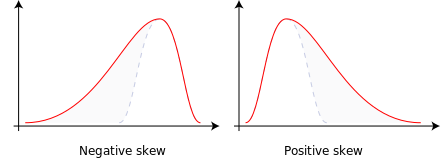


$$
skewness = E\Bigg[ \bigg(\frac{X-\mu}{\sigma} \bigg)^3 \Bigg] = \frac{\mu_3}{\sigma^3} = \frac{k_3}{k_2^{3/2}}
$$

Where $\mu$ is the mean, $\sigma$ is the standard deviation, $E$ is the [expectation operator](https://en.wikipedia.org/wiki/Expected_value), $\mu_3$ is the third [central moment](https://en.wikipedia.org/wiki/Central_moment), and $k_t$ are the t-th [cumulants](https://en.wikipedia.org/wiki/Cumulant). Here the $E$ is the mean.

In [203]:
# Self
np.mean((wake_eg - mean_wake) ** 3) / (sd_wake ** 3)

0.2265015921917623

In [213]:
f = 'skewness'
skew_wake = stats.skew(wake_eg)
skew_nrem = stats.skew(nrem_eg)
skew_rem = stats.skew(rem_eg)

print(f'Wake data {f}: {skew_wake:.4f}')
print(f'NREM data {f}: {skew_nrem:.4f}')
print(f'REM data {f}: {skew_rem:.4f}')

Wake data skewness: 0.2265
NREM data skewness: 0.2679
REM data skewness: 0.1618


### Kurtosis

$$
Kurtosis = E \Bigg[ \bigg(\frac{X-\mu}{\sigma} \bigg)^4 \Bigg] = \frac{E[(X-\mu)^4]}{\sigma^4}
$$

In [185]:
# Self, use Pearson's definition, normal ==> 3.0
np.mean((wake_eg - mean_wake) ** 4) / (sd_wake ** 4)

4.060988845870819

In [186]:
# Scipy.stats, use fisher's definition, normal ==> 0.0
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
f = 'kurtosis'
kurt_wake = stats.kurtosis(wake_eg)
kurt_nrem = stats.kurtosis(nrem_eg)
kurt_rem = stats.kurtosis(rem_eg)

print(f'Wake data {f}: {kurt_wake:.4f}')
print(f'NREM data {f}: {kurt_nrem:.4f}')
print(f'REM data {f}: {kurt_rem:.4f}')

Wake data kurtosis: 1.0610
NREM data kurtosis: 0.4492
REM data kurtosis: 0.1818


### Zero crossing
> The zero-crossing method is a systematic analysis method expressed in the waveform as the intersection of the waveform at that point with the horizontal midline of the waveform.

Calculating $X[i] \times X[i+1]$, and counting the number $N_z$ of $i$ satisfying $X[i] \times X[i+1] < 0$, the rate of zero crossing can be defined as follows:
$$
ZCR = \frac{N_z}{N}
$$

In [187]:
# Self
def zero_cross_rate(x):
    """
    Calculate the rate of zero crossing in a 1D array
    
    Parameters
    ----------
    x : np.array
        1-D data.
    
    Returns
    --------
    zero_cross_rate : float
        Rate of zero crossing in the array.
    """
    try:
        if len(x.shape) >= 2:
            raise ValueError(f'x must be 1D array, got {x.shape[0]}D')
    except AttributeError as e:
        raise AttributeError('x must be a np.array object') from e
        
    return np.diff(np.signbit(x)).sum() / x.shape[-1]

In [219]:
f = 'zero-crossing rate'
zcr_wake = zero_cross_rate(wake_eg)
zcr_nrem = zero_cross_rate(nrem_eg)
zcr_rem = zero_cross_rate(rem_eg)

print(f'Wake data {f}: {zcr_wake:.4f}')
print(f'NREM data {f}: {zcr_nrem:.4f}')
print(f'REM data {f}: {zcr_rem:.4f}')

Wake data zero-crossing rate: 0.0815
NREM data zero-crossing rate: 0.0553
REM data zero-crossing rate: 0.0776


In [220]:
from antropy import num_zerocross
num_zerocross(wake_eg, normalize=True)

0.08153005464480874

### Hjorth parameters
> [Hjorth parameters](https://en.wikipedia.org/wiki/Hjorth_parameters) are indicators of statistical properties used in signal processing, especially in Electroencephalography signals for feature extraction. Which is also known as the normalized slope descriptors (NSDs). The Hjorth parameters consists of three descriptors: Activity, Mobility and Complexity.

**1. Hjorth Activity**

Variance of the signal. This can indicate the average power of the EEG signal
$$
Activity = var(y(t))
$$
Where $y(t)$ represents the signal

**2. Hjorth Mobility**

The mobility parameter represents the mean frequency of the proportion of standard deviation of the power. This is defined as the square root of variance of the first derivative of the signal $y(t)$ divided by variance of the signal $y(t)$.
$$
Mobility = \sqrt{\frac{var(\frac{dy(t)}{dt})}{var(y(t))}}
$$

**3. Hjorth Complexity**

The complexity parameter represents the change in frequency. The parameter compared the signal's similarity to a pure sine wave, where the value converges to 1 if the signal is more similar.

$$
Complexity = \frac{Mobility(\frac{dy(t)}{dt})}{Mobility(y(t))}
$$

In [234]:
# self
def hjorth_params(x):
    """
    Calculate the hjorth parameters, consist activity, mobility and complexity
    
    Parameters
    ----------
    x : 1D array
        Signal data.
    
    Returns
    ----------
    x_var : float
        Hjorth activity
    mobility : float
        Hjorth mobility
    complexity : float
        Hjorth complexity
    """
    # Derivatives
    dx = np.diff(x)
    ddx = np.diff(dx)
    # Variance
    x_var = np.var(x)
    dx_var = np.var(dx)
    ddx_var = np.var(ddx)
    
    mobility = np.sqrt(dx_var / x_var)
    complexity = np.sqrt(ddx_var / dx_var) / mobility
    
    return x_var, mobility, complexity

In [231]:
f = 'Hjorth parameters (activity, mobility, complexity)'
hjorth_wake = hjorth_params(wake_eg)
hjorth_nrem = hjorth_params(nrem_eg)
hjorth_rem = hjorth_params(rem_eg)

print(f'Wake data {f}: {hjorth_wake[0]:.4f}, '
      f'{hjorth_wake[1]:.4f}, {hjorth_wake[2]:.4f}')
print(f'NREM data {f}: {hjorth_nrem[0]:.4f}, '
      f'{hjorth_nrem[1]:.4f}, {hjorth_nrem[2]:.4f}')
print(f'REM data {f}: {hjorth_rem[0]:.4f}, '
      f'{hjorth_rem[1]:.4f}, {hjorth_rem[2]:.4f}')

Wake data Hjorth parameters (activity, mobility, complexity): 2915.2250, 0.2455, 2.3164
NREM data Hjorth parameters (activity, mobility, complexity): 7527.4492, 0.1876, 2.5565
REM data Hjorth parameters (activity, mobility, complexity): 4476.4589, 0.2553, 2.0087


In [232]:
from antropy import hjorth_params
hjorth_params(wake_eg)

(0.24546354749710975, 2.3163607228697054)